## UNETR on Liver tumor 3D segmentation 

This notebook code is developed as part of EECS 545 course project at the University of Michigan
We have taken reference of code from [link](https://github.com/Project-MONAI/tutorials/blob/master/3d_segmentation/brats_segmentation_3d.ipynb)

## Multi-labels segmentation pipeline
1. Setting up of environment with various imports from MONAI library and Pytorch
1. Defining custom Transforms for data manipulation for ease of training for both liver & tumor segmentation.
1. Setting MONAI based transforms for Data augmentation.
1. Loading Nifti based data (images + segmentations), using the transforms defined, for training & validation.
1. Visualizing some of the data images & their corresponding segmentation masks.
1. Loading **UNETR model** from MONAI lib
1. Setting Dice loss function, Adam Optimizer, and starting a deterministic training for reproducibility.
1. Plotting loss and dice metrics.
1. Evaluating the best model weights.

## Dataset
The dataset comes from https://www.kaggle.com/datasets/andrewmvd/liver-tumor-segmentation?resource=download . 
Target: Liver and Tumor segmentation  
Modality: CT Scan  
Size: 131 3D volumes (101 Training + 30 Validation)  
Source: LiTS 2017 dataset.  

## Setup environment, imports

In [19]:
import os
import time
import argparse
import warnings

from glob import glob
import numpy as np
import torch
import matplotlib.pyplot as plt
from monai.networks.nets import SegResNet, UNet, UNETR
from monai.config import KeysCollection, print_config
from monai.networks.layers import Norm
from monai.data import DataLoader, CacheDataset, decollate_batch
from monai.utils import set_determinism
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference
from monai.transforms import(
    Compose,
    LoadImaged,
    ToTensord,
    Spacingd,
    Orientationd,
    ScaleIntensityRanged,
    EnsureChannelFirstd,
    RandSpatialCropd,
    Activations,
    AsDiscrete,
    CropForegroundd,
    Resized,
    MapTransform,
    RandFlipd,
    RandRotated,
)

print_config()

MONAI version: 1.2.dev2315
Numpy version: 1.23.5
Pytorch version: 2.0.0+cu118
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: d8703e4a1f7016706bb56e1bbe0a22693d5757c6
MONAI __file__: c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.1.0
scikit-image version: 0.20.0
Pillow version: 9.3.0
Tensorboard version: 2.12.1
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.15.1+cu118
tqdm version: 4.65.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.4
pandas version: NOT INSTALLED or UNKNOWN VERSION.
einops version: 0.6.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependenc

## Define a new transform to convert brain tumor labels

Here we convert the multi-classes labels into multi-labels segmentation task in One-Hot format.

In [20]:
root_dir = './' 
model_dir = './Task03_liver'
print(root_dir)
set_determinism(seed=0)

###Customised transform classes   

class ForceSyncAffined(MapTransform):
    """
    Forcefully set affines of targets to source's affine
    Mainly for fixing bad data points
    """

    def __init__(self, keys: KeysCollection, source_key: str, allow_missing_keys: bool = False) -> None:
        super().__init__(keys, allow_missing_keys)
        self.source_key = source_key    

    def __call__(self, data):
        d = dict(data)
        assert self.source_key in d, f"Source key {self.source_key} not in data point."
        s_data_affine = d[self.source_key].affine
        for key in self.key_iterator(d):
            d[key].affine = s_data_affine
        return d 
    

"""
Convert labels to multi channels based on LiTS classes:
label 1 is the liver mask
label 2 is the tumor
The possible classes are Background, Liver and Tumor.

"""
def convert_label_to_liver_classes(label):
    
    # Liver 
    class1 = (torch.logical_or(label == 1, label == 2)).float()

    # Tumor
    class2 = (label == 2).float()

    return torch.cat((class1,class2), 1)

./


## Import Data and setup transforms for training and validation

In [28]:
roi_size=[128, 128, 64]
pixdim=(1.5, 1.5, 1.0)
a_min=-200
a_max=200
cache_rate = 0.0

root= r"E:\Winter 2023 projects\DL+Medical Image segmentation\EECS 545_Med_Image_Segm\unetr_LiTS\LiTS_data"
path_train_volumes = sorted(glob(os.path.join(root, "images", "*.nii")))
path_train_segmentation = sorted(glob(os.path.join(root, "segmentations", "*.nii")))

train_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(path_train_volumes[0:60], path_train_segmentation[0:60])]
# val_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(path_train_volumes[101:131], path_train_segmentation[101:131])]
val_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(path_train_volumes[92:93], path_train_segmentation[92:93])]
# for i in range(60):
#     print(i)
#     print(val_files[i]['vol'])
train_transforms = Compose([
        LoadImaged(keys=["vol", "seg"]),
        ForceSyncAffined(keys=["seg"], source_key="vol"),
        EnsureChannelFirstd(keys=["vol", "seg"]),
        ScaleIntensityRanged(keys=["vol"], a_min=a_min, a_max=a_max, b_min=0.0, b_max=1.0, clip=True),
        Orientationd(keys=["vol", "seg"], axcodes="RAS"),
        Spacingd(keys=["vol", "seg"], pixdim=pixdim, mode=("bilinear", "nearest")),
        CropForegroundd(keys=['vol', 'seg'], source_key='vol'),
        RandSpatialCropd(keys=["vol", "seg"], roi_size=[-1,-1,roi_size[2]], random_size=False),
        RandRotated(keys=["vol", "seg"], prob=0.5, range_x=[0.2,0.2], mode=['bilinear', 'nearest']),
        Resized(keys=["vol", "seg"], spatial_size=roi_size),
        ToTensord(keys=["vol", "seg"]),
        ])

val_transforms = Compose([
        LoadImaged(keys=["vol", "seg"]),
        ForceSyncAffined(keys=["seg"], source_key="vol"),
        EnsureChannelFirstd(keys=["vol", "seg"]),
        ScaleIntensityRanged(keys=["vol"], a_min=a_min, a_max=a_max,b_min=0.0, b_max=1.0, clip=True),            
        Orientationd(keys=["vol", "seg"], axcodes="RAS"),
        Spacingd(keys=["vol", "seg"], pixdim=pixdim, mode=("bilinear", "nearest")),
        CropForegroundd(keys=['vol', 'seg'], source_key='vol'),
        Resized(keys=["vol", "seg"], spatial_size=(roi_size[0], roi_size[1],-1)),
        ToTensord(keys=["vol", "seg"]),
        ])

## Quickly load data with CacheDataset

In [29]:
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=cache_rate)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=cache_rate)
val_loader = DataLoader(val_ds, batch_size=1)

## Check data shape and visualize

image shape: torch.Size([1, 128, 128, 64])


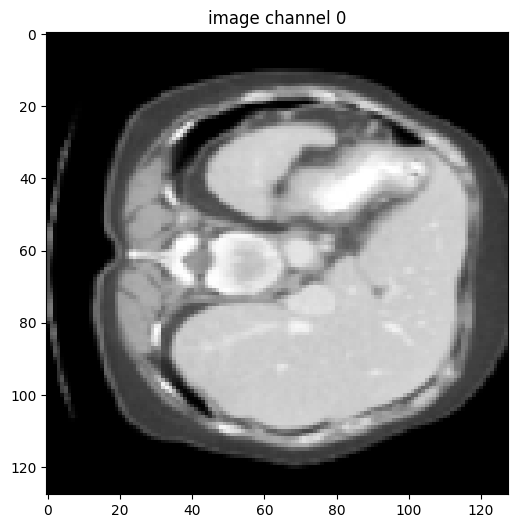

label shape: torch.Size([1, 128, 128, 64])


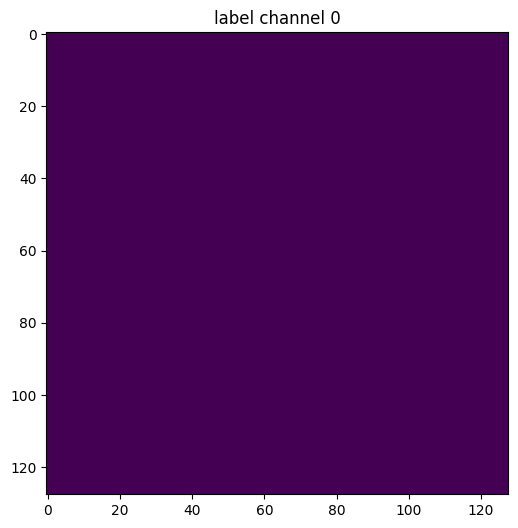

In [9]:
slice_id = 40 #tumor on slice 48 if total slices=64
patient = 0
print(f"image shape: {train_ds[patient]['vol'].shape}")
plt.figure("image", (24, 6))
for i in range(1):
    plt.subplot(1, 1, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(train_ds[patient]["vol"][0, :, :, slice_id].detach().cpu(),  cmap="gray") #
    
plt.show()
# also visualize the label corresponding to this image
print(f"label shape: {train_ds[patient]['seg'].shape}")
plt.figure("label", (24, 6))

for i in range(train_ds[patient]['seg'].shape[0]):
    plt.subplot(1, 3, i + 1)
    plt.title(f"label channel {i}")
    plt.imshow(train_ds[patient]["seg"][i, :, :, slice_id].detach().cpu())
    
plt.show()

## Proposed transormer based model

In [30]:
from monai.networks.nets import UNETR

# Set device
device = device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Use amp to accelerate training
scaler = torch.cuda.amp.GradScaler()
# Enable cuDNN benchmark
torch.backends.cudnn.benchmark = True

num_heads = 12 # 12 normally 
embed_dim= 768 # 768 normally

model = UNETR(
    in_channels=1,
    out_channels=2,
    img_size=tuple(roi_size),
    feature_size=16,
    hidden_size=embed_dim,
    mlp_dim=3072,
    num_heads=num_heads,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
    ).to(device)

pytorch_total_params = sum(p.numel() for p in model.parameters())/1000000
print('Parameters in millions:',pytorch_total_params)

Parameters in millions: 92.814562


## Create Model, Loss, Optimizer, Execute a typical PyTorch training process

In [7]:
import torch.nn as nn
from monai.losses import DiceLoss, DiceCELoss

max_epochs = 25#50#180
val_interval = 5

# Create loss, optimizer, lr_schedule and dice metrics
loss_function = DiceLoss(to_onehot_y=False, 
                         sigmoid=True, 
                         squared_pred=True, 
                         smooth_nr=0, 
                         smooth_dr=1e-5)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5, amsgrad=True)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)
dice_metric = DiceMetric(include_background=True, reduction="mean") 
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch") 

# Transformation for outputs to 2 classes with sigmoid activation
post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])

# Start training
best_metric = -1
best_metric_epoch = -1
save_loss = []
save_metric = []
save_metric_liver = []
save_metric_tumor = []
metric = 0.0
metric_liver = 0.0
metric_tumor = 0.0

train_start = time.time()

for epoch in range(max_epochs):
    epoch_start = time.time()
    print("-" * 20)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    batch_num = 0
    
    # Train from training ds
    for batch_data in train_loader:    
        batch_num += 1
        volume = batch_data["vol"]
        label = batch_data["seg"]
        label_tf = convert_label_to_liver_classes(label)
    
        check_label_size = ((label.size(dim=2) == roi_size[0]) and (label.size(dim=3) == roi_size[1]) and (label.size(dim=4) == roi_size[2]))
        check_affine =  torch.all(volume.affine == label.affine)
        if (check_affine and check_label_size):
            volume, label = (volume.to(device), label_tf.to(device))

            # Gradient solver and compute training loss
            optimizer.zero_grad()

            with torch.cuda.amp.autocast():  
                outputs = model(volume)
                train_loss = loss_function(outputs, label) 
            scaler.scale(train_loss).backward()
            scaler.step(optimizer)
            scaler.update()
            epoch_loss += train_loss.item()

            step += 1

            print(
                f"{batch_num}/{len(train_loader) // train_loader.batch_size}, "
                f"loss: {train_loss.item():.4f}")
        
        else:
            print(f"{batch_num}/{len(train_loader) // train_loader.batch_size}, label shape incorrect, skip training")
    
    lr_scheduler.step()
    epoch_loss /= step
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
    
    save_loss.append(epoch_loss)
    np.save(os.path.join(model_dir, 'epoch_loss.npy'), save_loss)

    if (epoch + 1) % val_interval == 0:
        model.eval()
        sw_batch_size = 1
        with torch.no_grad():
            for val_data in val_loader:
                val_volume = val_data["vol"]
                val_label = val_data["seg"]
                val_volume, val_label = (val_volume.to(device), val_label.to(device))

                with torch.cuda.amp.autocast():  
                    val_outputs = sliding_window_inference(val_volume, roi_size, sw_batch_size, model, overlap=0.5)

                # Compute each val metrics 
                val_outputs_tf = [post_trans(i) for i in decollate_batch(val_outputs)]
                val_label_tf = convert_label_to_liver_classes(val_label)
                dice_metric(y_pred=val_outputs_tf, y=val_label_tf)
                dice_metric_batch(y_pred=val_outputs_tf, y=val_label_tf)      
            
            # Get mean metrics
            metric = dice_metric.aggregate().item()
            dice_metric.reset()

            # Get batch metrics
            metric_val_batch = dice_metric_batch.aggregate()
            metric_liver = metric_val_batch[0].item()
            metric_tumor = metric_val_batch[1].item()
            dice_metric_batch.reset()
        
    # save metrics
    save_metric.append(metric)
    save_metric_liver.append(metric_liver)
    save_metric_tumor.append(metric_tumor)
    np.save(os.path.join(model_dir, 'metric_mean.npy'), save_metric)
    np.save(os.path.join(model_dir, 'metric_liver.npy'), save_metric_liver)
    np.save(os.path.join(model_dir, 'metric_tumor.npy'), save_metric_tumor)

    # save model with best metric
    if metric > best_metric:
        best_metric = metric
        best_metric_epoch = epoch + 1
        torch.save(model.state_dict(), 
                    os.path.join(model_dir, "best_metric_model.pth"))
    print(
        f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
        f" liver: {metric_liver:.4f} tumor: {metric_tumor:.4f}"
        f"\nbest mean dice: {best_metric:.4f} at epoch: {best_metric_epoch}"
    )

    print(f"time consumed for epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")

# Train complete
print(
f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch},"
f" total train time: {(time.time() - train_start):.4f}"
)


--------------------
epoch 1/25
1/25, loss: 0.9227
2/25, loss: 0.9254
3/25, loss: 0.9069
4/25, loss: 0.9190
5/25, loss: 0.9468
6/25, loss: 0.8091
7/25, loss: 0.7552
8/25, loss: 0.7476
9/25, loss: 0.9101
10/25, loss: 1.0000
11/25, loss: 0.9584
12/25, loss: 0.8573
13/25, loss: 0.8827
14/25, loss: 0.8307
15/25, loss: 0.8017
16/25, loss: 0.9891
17/25, loss: 0.8642
18/25, loss: 0.8507
19/25, loss: 1.0000
20/25, loss: 0.8603
21/25, loss: 0.8821
22/25, loss: 0.9888
23/25, loss: 1.0000
24/25, loss: 0.8467
25/25, loss: 1.0000
26/25, loss: 0.8351
27/25, loss: 0.9071
28/25, loss: 0.9983
29/25, loss: 0.7186
30/25, loss: 0.8212
31/25, loss: 0.9987
32/25, loss: 0.9433
33/25, loss: 0.7887
34/25, loss: 0.7348
35/25, loss: 1.0000
36/25, loss: 0.9832
37/25, loss: 0.8318
38/25, loss: 0.8257
39/25, loss: 0.8622
40/25, loss: 0.8627
41/25, loss: 0.8001
42/25, loss: 0.8907
43/25, loss: 0.9055
44/25, loss: 0.9063
45/25, loss: 0.7835
46/25, loss: 0.9473
47/25, loss: 0.8400
48/25, loss: 0.6746
49/25, loss: 0.97

In [8]:

# unet tutorial result: train completed, best_metric: 0.7537  at epoch: 160 # official tutorial
# train completed, best_metric: 0.7660 at epoch: 170 # my run

# self-attention-cv implementation of unetr
# current epoch: 180 current mean dice: 0.7686 tc: 0.8116 wt: 0.8935 et: 0.6065
# best mean dice: 0.7686 at epoch: 180

# reduced version 50m params
# current epoch: 180 current mean dice: 0.7693 tc: 0.8161 wt: 0.8922 et: 0.6057
# best mean dice: 0.7693 at epoch: 180

# unetr monai implementation
# current epoch: 175 current mean dice: 0.7612 tc: 0.8122 wt: 0.8790 et: 0.5982 

## Plot the loss and metric

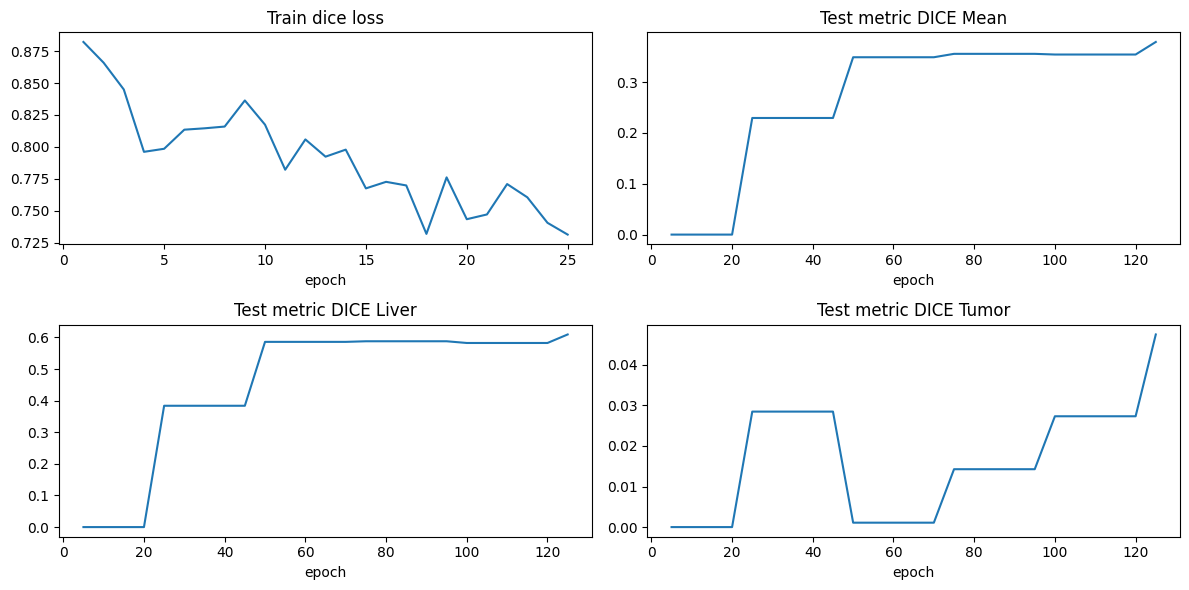

In [9]:
plt.figure("train", (12, 6))
plt.subplot(2, 2, 1)
plt.title("Train dice loss")
x = [i + 1 for i in range(len(save_loss))]
y = save_loss
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(2, 2, 2)
plt.title("Test metric DICE Mean")
x = [val_interval * (i + 1) for i in range(len(save_metric))]
y = save_metric
plt.xlabel("epoch")
plt.plot(x, y)

plt.figure("train", (12, 6))
plt.subplot(2, 2, 3)
plt.title("Test metric DICE Liver")
x = [val_interval * (i + 1) for i in range(len(save_metric_liver))]
y = save_metric_liver
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(2, 2, 4)
plt.title("Test metric DICE Tumor")
x = [val_interval * (i + 1) for i in range(len(save_metric_tumor))]
y = save_metric_tumor
plt.xlabel("epoch")
plt.plot(x, y)
plt.tight_layout()
plt.show()

## Check best model output with the input image and label

torch.Size([1, 1, 128, 128, 459])


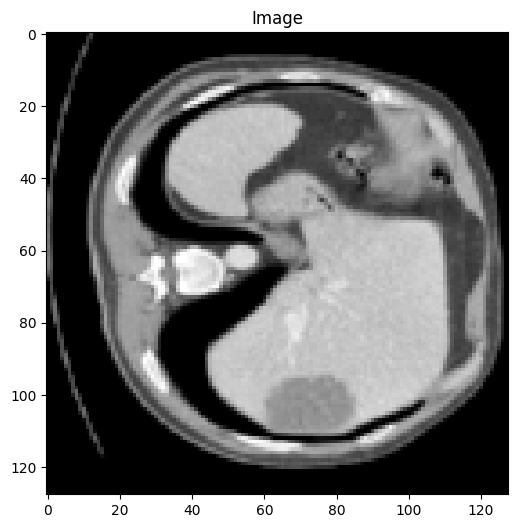

In [33]:
model.load_state_dict(
    torch.load(os.path.join(model_dir, "best_metric_600.pth"))
)
model.eval()
slice_id = 400
sw_batch_size = 1

# Transformation for outputs to 2 classes with sigmoid activation
post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])
i=1
with torch.no_grad():
    for val_data in val_loader:
        val_volume = val_data["vol"]
        val_label = val_data["seg"]
        val_volume, val_label = (val_volume.to(device), val_label.to(device))
        print(val_volume.shape)
        with torch.cuda.amp.autocast():  
            val_outputs = sliding_window_inference(val_volume, roi_size, sw_batch_size, model, overlap=0.5)

        # Compute each val metrics 
        val_outputs_tf = [post_trans(i) for i in decollate_batch(val_outputs)]
        val_label_tf = convert_label_to_liver_classes(val_label)
        # print("image.shape", val_volume.shape)
        # print("ground truth shape", val_label_tf[0].shape)
        # print("UNETR output shape", val_outputs_tf[0].shape)
        
        plt.figure("output", (18, 6))
    
        # plt.subplot(1, 3, 1)
        plt.title(f"Image")
        plt.imshow(val_volume[0, 0, :, :,slice_id].detach().cpu(), cmap="gray")

        # plt.subplot(1, 3, 2)
        # plt.title(f"Ground Truth")
        # gt_liver_tumor = torch.zeros_like(val_label_tf[0,1, :, :, slice_id])
        # gt_healthy_liver = val_label_tf[0,0, ..., slice_id] == 1
        # gt_unhealthy_liver = val_label_tf[0,1, ..., slice_id] == 1
        # gt_liver_tumor[gt_healthy_liver] = 1
        # gt_liver_tumor[gt_unhealthy_liver] = 2
        # plt.imshow(gt_liver_tumor.detach().cpu(), vmin=0, vmax=2)

        # plt.subplot(1, 3, 3)
        # plt.title(f"UNETR output")
        # pred_liver_tumor = torch.zeros_like(val_outputs_tf[0][0, :, :, slice_id])
        # pred_healthy_liver = val_outputs_tf[0][0, ..., slice_id] >= 0.5
        # pred_unhealthy_liver = val_outputs_tf[0][1, ..., slice_id] >= 0.5
        # pred_liver_tumor[pred_healthy_liver] = 1
        # pred_liver_tumor[pred_unhealthy_liver] = 2
        # plt.imshow(pred_liver_tumor.detach().cpu(), vmin=0, vmax=2)
        plt.show()
        